In [1]:
import os
import sys

os.environ['CUDA_VISIBLE_DEVICES'] = '3'
sys.path.append('../')

import wandb
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from torch.utils.data import DataLoader
from data_utils import get_eval_data
from model.unet import get_unet
from utils import epoch_average
from monai.metrics import DiceMetric
from omegaconf import OmegaConf
from pathlib import Path
from typing import Dict

In [2]:
test_vendors = ['philips', 'ge']

LOG = False
ITERATION = 0
DATA_KEY = 'prostate'
# VENDOR = test_vendors[0]
VENDOR = 'siemens'
LOAD_ONLY_PRESENT = False
extra_description = ''

cfg = OmegaConf.load('../configs/conf.yaml')
OmegaConf.update(cfg, 'run.iteration', ITERATION)
OmegaConf.update(cfg, 'run.data_key', DATA_KEY)

unet_name = 'monai-64-4-4'
args = unet_name.split('-')
cfg.unet[DATA_KEY].pre = unet_name
cfg.unet[DATA_KEY].arch = args[0]
cfg.unet[DATA_KEY].n_filters_init = None if unet_name == 'swinunetr' else int(args[1])
cfg.unet[DATA_KEY].training.vendor = VENDOR
cfg.unet[DATA_KEY].training.load_only_present = LOAD_ONLY_PRESENT
cfg.wandb.project = f'{DATA_KEY}_{unet_name}_{ITERATION}{extra_description}'
cfg.wandb.log = LOG
# Set cfg.format to "numpy" for evaluation, otherwise don't modify it or set to "torch" for training
cfg.format = 'numpy'
cfg.unet[DATA_KEY].training.subset = True # Applies for evaluation dataset only

if args[0] == 'monai':
    cfg.unet[DATA_KEY].depth = int(args[2])
    cfg.unet[DATA_KEY].num_res_units = int(args[3])

if LOG:
    wandb.init(
        project=cfg.wandb.project,
        config={
            "learning_rate": cfg.unet[DATA_KEY].training.lr,
            "architecture": unet_name,
            "dataset": DATA_KEY
        }
    )

In [3]:
unet, state_dict = get_unet(cfg, update_cfg_with_swivels=False, return_state_dict=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unet.to(device);

In [4]:
data = get_eval_data(train_set=False, val_set=False, eval_set=True, cfg=cfg)
eval_dataset = data['eval']
print(len(eval_dataset))

Loading evaluation PMRI dataset...
445


In [19]:
def eval_set(cfg, model, dataset):
    if cfg.run.data_key == 'prostate':
        dataloader = DataLoader(dataset, batch_size=16,
                                shuffle=False, drop_last=False)

        eval_metrics = {
            "Dice Score": DiceMetric(
                ignore_empty=False
            )
        }

        metrics = eval_pmri_set(
            model=model,
            dataloader=dataloader,
            eval_metrics=eval_metrics
        )
    else:
        raise ValueError(
            f'Invalid data key. No config for dataset named {cfg.run.data_key}'
        )
    return metrics

@torch.no_grad()
def eval_pmri_set(model, dataloader, eval_metrics):
    model.eval()
    epoch_metrics = {key: [] for key in eval_metrics.keys()}
    batch_sizes = []
    for batch in dataloader:
        input_ = batch['input'] # .float()
        target = batch['target'] # .long()
        batch_sizes.append(input_.shape[0])
        out = model(input_.cuda()).detach().cpu()
        for key, metric in eval_metrics.items():
            computed_metric = metric(out, target).detach().mean().cpu()
            epoch_metrics[key].append(computed_metric)

    print(epoch_metrics)
    for key, epoch_scores in epoch_metrics.items():
        epoch_metrics[key] = epoch_average(epoch_scores, batch_sizes)
    return epoch_metrics

def get_df_from_dict(cfg, metrics: Dict):
    # convert dict into seaborn-friendly pandas format
    df = pd.DataFrame.from_dict(metrics).T
    df['Domain'] = df.index
    df.reset_index(drop=True, inplace=True)
    df = pd.melt(
        df, 
        id_vars=['Domain'],
        value_vars=df.columns.drop('Domain')
    )
    # add additional identifiers from config
    df['Iteration'] = cfg.run.iteration
    df['Model'] = cfg.unet[cfg.run.data_key].pre
    df['Data'] = cfg.run.data_key
    return df

def plot_batch(dataset, model, num_images=9):
    assert 0 < num_images <= 9
    idx = random.sample(range(len(dataset)), num_images)
    data = dataset[idx]
    print(data['input'].shape)
    with torch.no_grad():
        model.eval()
        pred = model(data['input'].cuda()).detach().cpu()
        pred = torch.argmax(pred, dim=1)

    fig, axes = plt.subplots(num_images, 2, figsize=(num_images*2, 5))

    # Iterate over the images and plot them in the grid
    print(pred.shape)
    for i in range(num_images):
        axes[i, 0].imshow(data['input'][i][0, ...], cmap='gray')
        axes[i, 1].imshow(pred[i], cmap='gray')
        axes[i, 0].axis('off')
        axes[i, 1].axis('off')

    # Adjust the spacing between subplots
    plt.subplots_adjust(wspace=0.1, hspace=0.1)

    # Show the plot
    plt.show()


Entry shape (1, 384, 384, 9) (1, 384, 384, 9)
Final shape torch.Size([9, 1, 256, 256]) torch.Size([9, 1, 256, 256])
torch.Size([9, 1, 256, 256])
torch.Size([9, 256, 256])


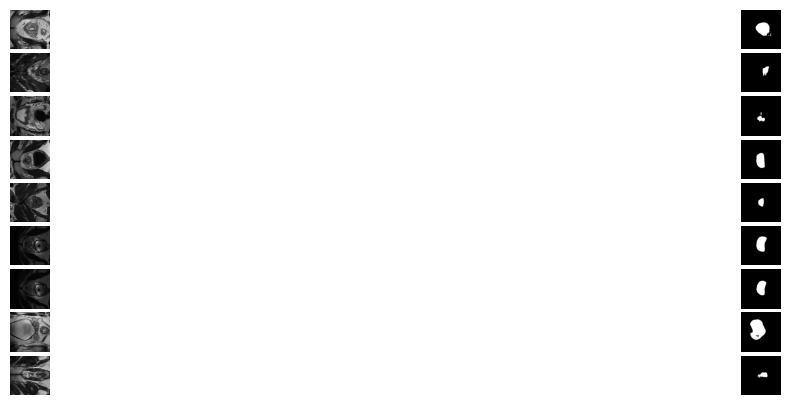

In [20]:
plot_batch(eval_dataset, unet)

{'Dice Score': [tensor(0.5000), tensor(0.5181), tensor(0.5482), tensor(0.5023), tensor(0.5247), tensor(0.5060), tensor(0.5450), tensor(0.5310), tensor(0.5166), tensor(0.5226), tensor(0.5373), tensor(0.5259), tensor(0.5221), tensor(0.5309), tensor(0.5401), tensor(0.5632), tensor(0.5253), tensor(0.5000), tensor(0.5100), tensor(0.5442), tensor(0.5053), tensor(0.5000), tensor(0.5056), tensor(0.5399), tensor(0.5000), tensor(0.5239), tensor(0.5364), tensor(0.5546)]}


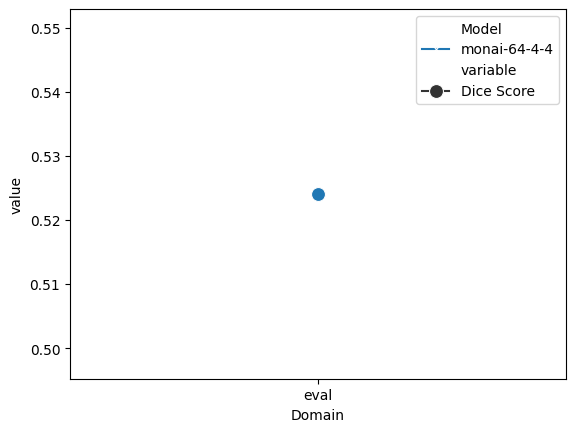

In [17]:
metrics = {}

for key in data.keys():
    metrics[key] = eval_set(
        cfg=cfg,
        model=unet,
        dataset=data[key]
    )

df = get_df_from_dict(cfg, metrics)

sns.lineplot(
    data=df, 
    x='Domain', 
    y='value', 
    hue='Model',
    style='variable',
    markers=True, 
    dashes=False, 
    markersize=10, 
    marker='x'
)

plt.show()